In [1]:
import cv2
cv2.__version__

'4.5.4'

In [2]:
# import sample data
from skimage.data import cells3d
#import ndimage

import napari
import vispy.color
import vtk
import tetgen
import scipy
import statistics as st
import pymeshlab
import xlsxwriter

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import meshlib
import pyvista as pv
import meshio

from csbdeep.utils import normalize
from scipy import ndimage as ndi
from collections import deque

from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

from napari.settings import get_settings

import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn

from vispy.color import Colormap
from IPython.display import display_html
from IPython.display import clear_output

from aicsimageio import AICSImage

from skimage.measure import marching_cubes
#from mayavi import mlab
from scipy.spatial import Delaunay

settings = get_settings()
settings.application.ipy_interactive = True

2025-01-08 14:28:44.471904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 14:28:44.472684: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 14:28:44.476258: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 14:28:44.515236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 14:28:45.202217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## File information
In this cell is possible to add information about the input file. 
[zstack_file] is the full name of the file (including extension); [ch_color] is the order of channel colors identified by their name or HEX value; [ch_names] is the name associated to each marker in each channel of the image; [coord_order] is the visualization order of the 3D coordinates when the file is open in Napari.

In [3]:
# Get the AICSImage object
zstack_file='2024-w19-primary-lecs-20X.lif' 
img = AICSImage(zstack_file)

ch_color=['green','blue']
ch_names=['C1', 'NUCLEI']
coord_order='ZYX'

In [4]:
img.get_image_dask_data("YZX")  # dask.array.Array

dask.array<transpose, shape=(1954, 63, 20301), dtype=uint8, chunksize=(1954, 63, 20301), chunktype=numpy.ndarray>

In [5]:
original_ch_names=img.channel_names

In [6]:
r_X=img.physical_pixel_sizes.X
r_Y=img.physical_pixel_sizes.Y
r_Z=img.physical_pixel_sizes.Z/3.0
print([r_X,r_Y,r_Z])

[0.5664162561576355, 0.5664162826420891, 2.000016129032258]


In [7]:
im_in=img.get_image_data(coord_order, C=0, S=0, T=0)

contrast_limits = {n: [0, 255] for n in ch_names}

for i in range(0,len(coord_order)):
    globals()[coord_order[i]+'max']=int(np.shape(im_in)[i])
    globals()[coord_order[i]+'min']=0

#### Functions
This cell contains all the functions that can be used for image processing.

In [8]:
def non_proc(im_in):
    return im_in.copy()

def ln_trans(im_in):
    val_c = 255.0 / np.log(1.0 + np.max(im_in))
    im_out = (val_c * (np.log(im_in + 1.0))).astype(int)
    return im_out.copy()

def exp_trans(im_in,val_a):
    val_c = 255.0 / ((1.0 + val_a)**np.max(im_in) - 1.0)
    im_out = (val_c*((1.0 + val_a)**im_in - 1.0))
    return im_out.copy()

def gamma_trans(im_in,gamma):
    val_c = 255.0 / (np.max(im_in)**gamma)
    im_out = val_c*(im_in**gamma)
    return im_out.copy()

def hist_slide_inc(im_in,shift_in):
    lim=255-shift_in
    im_out[im_in > lim] = 255
    im_out[im_in <= lim] += shift_in
    return im_out.copy()

def hist_slide_dec(im_in,shift_dec):
    lim=shift_dec
    im_out[im_in < lim] = 0
    im_out[im_in >= lim] -= shift_dec
    return im_out.copy()

def cont_stretch(im_in):
    val_a, val_b = 0.0, 255.0
    val_c, val_d = im_in.min(), im_in.max()
    im_out=((im_in-val_c)*((val_b - val_a)/(val_d-val_c)) + val_a).astype(int)
    return im_out.copy()

def contr_limit(im_in,c_min,c_max):
    alpha = 255.0/(c_max - c_min)
    beta = - c_min * (alpha)
    im_out=(np.clip(alpha*im_in+beta, 0.0, 255.0)).astype(int)
    #print(np.max(im_out))
    return im_out.copy()
    
def histo_equal(im_in):
    h=im_in.shape[1]
    w=im_in.shape[2]
    r=im_in.shape[0]

    tot_pixs=h*w*r

    levels=256

    im_hist = np.zeros((levels))

    for i in range(0,levels):
        im_hist[i] = np.count_nonzero(im_in == i)

    pdf = np.zeros((levels))
    for i in range(0,levels):
        pdf[i] = im_hist[i]/tot_pixs

    cdf = np.zeros((levels))
    cdf[0] = pdf[0]
    for i in range(1, levels):
        cdf[i] = pdf[i] + cdf[i-1]

    im_out=im_in.copy()
        
    for u in range(0,r):
        for j in range(0,h):
            for k in range(0,w):
                im_out[u,j,k] = int(round((levels-1) * cdf[im_in[u,j,k]]))
    return im_out.copy()

In [9]:
def on_shape_added(layer, event):
    shapes_layer= event.source

In [10]:
def label_islands_3d(matrix):
    """
    Labels connected islands in a 3D matrix using BFS.

    Args:
        matrix (np.ndarray): 3D binary matrix where `1` indicates part of an island.

    Returns:
        np.ndarray: 3D matrix with unique labels for each island.
    """
    def bfs(start_x, start_y, start_z, label):
        # Initialize the queue with the starting point
        queue = deque([(start_x, start_y, start_z)])
        matrix[start_x, start_y, start_z] = label  # Mark the starting point

        while queue:
            x, y, z = queue.popleft()
            
            # Explore all 26 neighbors in 3D space
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    for dz in [-1, 0, 1]:
                        if dx == 0 and dy == 0 and dz == 0:
                            continue  # Skip the center voxel

                        nx, ny, nz = x + dx, y + dy, z + dz
                        # Check bounds and if the neighbor is part of the island
                        if (0 <= nx < matrix.shape[0] and
                            0 <= ny < matrix.shape[1] and
                            0 <= nz < matrix.shape[2] and
                            matrix[nx, ny, nz] == 1):
                            matrix[nx, ny, nz] = label  # Label the neighbor
                            queue.append((nx, ny, nz))

    label = 2  # Start labeling from 2 (1 is used for the original matrix)
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            for z in range(matrix.shape[2]):
                if matrix[x, y, z] == 1:  # Found an unvisited island
                    bfs(x, y, z, label)
                    label += 1  # Increment label for the next island

    return matrix-(matrix>0).astype(int)

## TRIGGERS
Put false to silence some operations.

In [11]:
trig_show_original=True
trig_ROI_evaluate=True
trig_contrast_limits_evaluate=True
trig_remove_noise=True
trig_transform=True
trig_filter=True
trig_threshold=True
trig_watershed=True
trig_stardist=False
trig_fill=True
trig_vtk_creation=True
trig_stl_creation=True

## ROI and contrast selection
Create a rectangular ROI in the full image in the ROI layer. Change the contrast limits for the channels to adapt image processing in the next steps.

In [13]:
if trig_show_original: 

    viewer_0 = napari.Viewer()
        
    for c, c_name in enumerate(ch_names):
        im_in=img.get_image_data(coord_order, C=c, S=0, T=0)
        
        viewer_0.add_image(im_in, name=c_name, 
                            colormap=ch_color[c], blending='additive')

    if trig_ROI_evaluate:
        settings.application.ipy_interactive = False
        shapes_layer = viewer_0.add_shapes(shape_type="rectangle", name="ROI")
        
        # Connect the click event to our callback function
        viewer_0.mouse_drag_callbacks.append(on_shape_added)
        
        napari.run()

        Ymax=int(np.max(shapes_layer.data[0][:,0]))
        Xmax=int(np.max(shapes_layer.data[0][:,1]))
        Ymin=int(np.min(shapes_layer.data[0][:,0]))
        Xmin=int(np.min(shapes_layer.data[0][:,1]))

        shapes_layer=[]

    if trig_contrast_limits_evaluate:
        image_layers = [layer for layer in viewer_0.layers if isinstance(layer, napari.layers.Image)]
        contrast_limits = {layer.name: layer.contrast_limits for layer in image_layers}

        print(contrast_limits)
        
settings.application.ipy_interactive = True

image.py (251): data shape (1954, 20301) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
image.py (251): data shape (1954, 20301) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
image.py (251): data shape (1954, 20301) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
image.py (251): data shape (1954, 20301) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.


/usr/local/lib/python3.10/dist-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (1954, 20301) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.!
{'C1': [0, 255], 'NUCLEI': [0, 255]}


NUCLEI 128 / 128


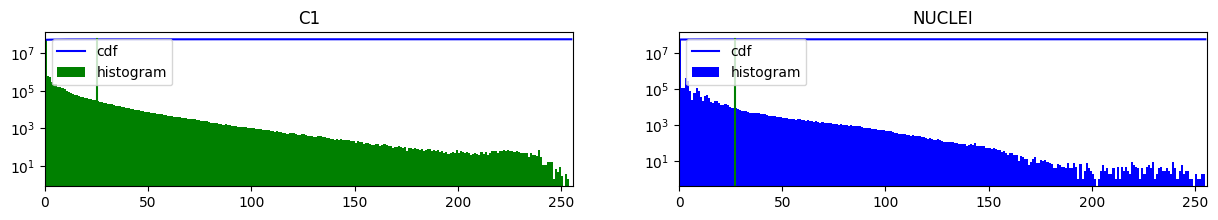

In [19]:
viewer_0 = napari.Viewer()
viewer_1 = napari.Viewer()
img = AICSImage(zstack_file) 

train_scale=[globals()['r_'+coord_order[0]],globals()['r_'+coord_order[1]],globals()['r_'+coord_order[2]]]
train_factor=[1.0,1.0,1.0]

coord_order='XYZ'

channel_list = [x for x in ch_names if x != 'NUCLEI']

fig, axs = plt.subplots(1,np.shape(ch_color)[0],figsize=(15,2))

for c, c_name in enumerate(ch_names):
    im_in=img.get_image_data(coord_order, C=c, S=0, T=0)
    im_in=im_in[globals()[coord_order[0]+'min']:globals()[coord_order[0]+'max'],globals()[coord_order[1]+'min']:globals()[coord_order[1]+'max'],globals()[coord_order[2]+'min']:globals()[coord_order[2]+'max']].copy()

    im_out=im_in.copy()
    print_im=im_out.copy()

    # REMOVE NOISE
    im_in=im_out.copy()
    
    if trig_remove_noise:
        im_out=filters.median(im_in)

        print_im=im_out.copy()
        
    #FILTERING
    im_in=im_out.copy()
    
    if trig_filter:
        im_out=filters.gaussian(im_in,0.5,preserve_range=True)
        
        print_im=im_out.copy()

    #HISTOGRAM TRANSFORMATION
    im_in=im_out.copy()

    if trig_transform:

        func_list=[contr_limit(im_in,contrast_limits[c_name][0],contrast_limits[c_name][1]),contr_limit(im_in,contrast_limits[c_name][0],contrast_limits[c_name][1])]

        im_out=func_list[c]
        im_trans=im_out.copy()
        print_im=im_out.copy()

    #THRESHOLDING
    im_in=im_out.copy()
    
    if trig_threshold:
        nda=sitk.GetImageFromArray(im_in)
        thval=200
        
        otsu_filter = sitk.OtsuThresholdImageFilter()
        otsu_filter.SetInsideValue(0)
        otsu_filter.SetOutsideValue(thval)
        seg = otsu_filter.Execute(nda)
    
        val=otsu_filter.GetThreshold()
              
        im_out=sitk.GetArrayFromImage(seg)
        im_th=im_out.copy()
        print_im_1=im_out.copy()

    #FILTERING
    im_in=im_out.copy()
    
    if not(trig_threshold & trig_filter):
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        im_out=im_out.astype('uint8')
        
    print_im_0=im_out.copy()

    #THRESHOLDING
    im_in=im_out.copy()

    labels=im_th.copy()
    im_labels=im_trans.copy()
    
    if trig_watershed and ch_names[c]=='NUCLEI':
        if trig_stardist:
            model = StarDist3D.from_pretrained('3D_demo')
            img_te = normalize(im_labels,1.0,99.8)
            labels, _ = model.predict_instances(img_te,scale=(r_Z,1.9*r_Y,1.9*r_X),prob_thresh=0.71, nms_thresh=0.3)

        elif trig_fill:
            labels=label_islands_3d(im_in/thval)            

        else:
            distance = ndi.distance_transform_edt(im_in)
            coords = peak_local_max(distance, footprint=np.ones((3,3,3)), labels=im_in.astype('uint8'))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = ndi.label(mask)
            labels = watershed(-distance, markers, mask=im_in)
        
        im_mask=im_th/np.max(im_th)
        im_mask=ndi.binary_erosion(im_mask,structure=np.ones((2,2,2))).astype(im_mask.dtype)
        im_positive=labels*(im_mask)
        list_positive=list(np.unique(im_positive))
        list_positive=list_positive[1:]
        print('TOTAL NUCLEI ' + str(len(list_positive)))

    cm=np.random.rand(1000,3)
    cm[0,:]=[0.0,0.0,0.0]
    colormaps_water=Colormap(cm)

    lab_0=labels.copy()

    globals()[c_name+'lab']=labels.copy()
    globals()[c_name+'mag']=im_labels.copy()
    print_im_water=labels.copy()

    #NAPARI UPLOAD
    viewer_0.add_image(labels, name=c_name, 
                        colormap=ch_color[c], blending='additive')
    viewer_1.add_image(print_im_0, name=c_name, 
                        colormap=ch_color[c], blending='additive')

    viewer_0.scale_bar.visible=True
    viewer_0.scale_bar.unit='um'
    viewer_1.scale_bar.visible=True
    viewer_1.scale_bar.unit='um'
    
    #STL CREATOR
    if trig_stl_creation:
        im_stl=im_th
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_stl))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(r_X,r_Y,r_Z), 0.5) 
        mr.saveMesh(mesh_stl, zstack_file[:-4]+"_"+ch_names[c]+"_mesh.stl" )

    #HISTOGRAM PLOTTING
    hist,bins = np.histogram(im_trans.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf* hist.max()/ cdf.max()

    axs[c].plot(cdf_normalized, color = 'b')
    if ch_color[c]=='white':
        axs[c].hist(im_trans.flatten(),256,[0,256], color = 'gray')
    else:
        axs[c].hist(im_trans.flatten(),256,[0,256], color = ch_color[c])
    axs[c].set_xlim([0,256])
    axs[c].legend(('cdf','histogram'), loc = 'upper left')
    if trig_threshold:
        axs[c].plot([val,val],[0,cdf_normalized.max()],color='g')
    axs[c].set_title(c_name)
    axs[c].set_yscale('log')

#VTK NUCLEI LABELLED

if trig_watershed and trig_vtk_creation:
    diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
    blocks_nuclei=pv.MultiBlock()
    nuclei_stl_old=mr.Mesh()

    nuc_vol=np.zeros((len(list_positive)+1,))
    nuc_coord=np.zeros((len(list_positive)+1,3))
    nuc_list=np.zeros((len(list_positive)+1,))
    agg_id=1

    k=0
    for j, val in enumerate(list_positive):
        clear_output(wait=True)
        print('NUCLEI ' + str(j+1) + ' / ' + str(len(list_positive)))
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(NUCLEIlab==val))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(globals()['r_'+coord_order[0]], globals()['r_'+coord_order[1]], globals()['r_'+coord_order[2]]), 0.5)    
        mr.saveMesh(mesh_stl, "part_nuclei_mesh.stl" )
        
        mesh_nuclei = pv.read("part_nuclei_mesh.stl")
        if mesh_nuclei.volume>300.0:
            mesh_nuclei.decimate(target_reduction=0.8, inplace=True)

            nuc_vol[k]=mesh_nuclei.volume
            nuc_coord[k]=mesh_nuclei.center
            nuc_list[k]=val
    
            mesh_nuclei.cell_data['nuceli_id']=np.ones(mesh_nuclei.n_cells)*(k+1)
            mesh_nuclei.cell_data['nuclei_vol']=np.ones(mesh_nuclei.n_cells)*nuc_vol[k]
            mesh_nuclei.cell_data['nuclei_'+coord_order[0]]=np.ones(mesh_nuclei.n_cells)*(Xmin+nuc_coord[k][0])
            mesh_nuclei.cell_data['nuclei_'+coord_order[1]]=np.ones(mesh_nuclei.n_cells)*(Ymin+nuc_coord[k][1])
            mesh_nuclei.cell_data['nuclei_'+coord_order[2]]=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][2]
            for c, channel in enumerate(channel_list):
                ass_channel=globals()[channel+'lab']*(NUCLEIlab==val)/np.max(globals()[channel+'lab'])
                mesh_nuclei.cell_data[channel+'_perc_abs']=np.ones(mesh_nuclei.n_cells)*(np.sum(ass_channel)/np.sum(NUCLEIlab==val))
                ass_channel_2=globals()[channel+'mag']*(NUCLEIlab==val)/np.max(globals()[channel+'mag'])
                mesh_nuclei.cell_data[channel+'_perc_rel']=np.ones(mesh_nuclei.n_cells)*(np.sum(ass_channel_2)/np.sum(NUCLEIlab==val))
            
            blocks_nuclei.append(mesh_nuclei)
            k=k+1

        j=j-1

    nuc_vol=nuc_vol[0:k-1]
    nuc_coord=nuc_coord[0:k-1]
    nuc_list=nuc_list[0:k-1]
    blocks_nuclei.extract_geometry().save(zstack_file[:-4]+'_NUCLEI_labelled.vtk')

## QUANTIFICATION

TOTAL NUCLEI 77


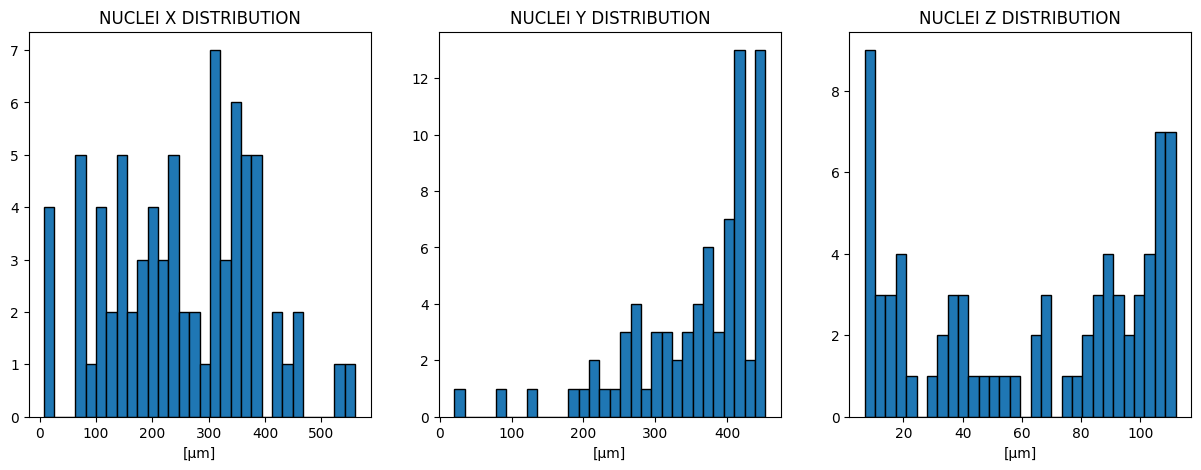

In [20]:
print('TOTAL NUCLEI ' + str(len(nuc_coord)))

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].hist(nuc_coord[1:,coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),edgecolor='black')
axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[1].hist(nuc_coord[1:,coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),edgecolor='black')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
axs[2].hist(nuc_coord[1:,coord_order.find('Z')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Z')]),max(nuc_coord[1:,coord_order.find('Z')])),edgecolor='black')
axs[2].set_title('NUCLEI Z DISTRIBUTION')
axs[2].set_xlabel('[μm]')
plt.show()

## Create a complete report XSL

Create a .xlsx file with one sheet, listing all the cells, their position, nuceli volume and relative value of marker positivity.

In [16]:
workbook=xlsxwriter.Workbook(zstack_file[:-4]+'.xlsx')

## FORMATS
header=workbook.add_format({'bold':True})
header.set_bg_color('yellow')
floats=workbook.add_format({'num_format':'0.00'})
floats_perc=workbook.add_format({'num_format':'0.00%'})

## CHONDROCYTES
worksheet_cell=workbook.add_worksheet('Cells')

#HEADER
worksheet_cell.write_row('A1:E1',['#ID','X','Y','Z','Volume Nuclei'],header)
for c, channel in enumerate(channel_list):
    worksheet_cell.write(0,5+c*2,channel,header)
    worksheet_cell.write(0,6+c*2,channel+' % vol',header)
    
#CONTENT
for row, val in enumerate(nuc_list):
    worksheet_cell.write(row+1,0,row+1)
    worksheet_cell.write(row+1,1,nuc_coord[row][coord_order.find('X')],floats)
    worksheet_cell.write(row+1,2,nuc_coord[row][coord_order.find('Y')],floats)
    worksheet_cell.write(row+1,3,nuc_coord[row][coord_order.find('Z')],floats)
    clear_output(wait=True)
    print('NUCLEI ' + str(row+1) + ' / ' + str(len(nuc_coord)))
    worksheet_cell.write(row+1,4,nuc_vol[row],floats)
    for c, channel in enumerate(channel_list):
        ass_channel=globals()[channel+'lab']*(NUCLEIlab==val)/thval
        worksheet_cell.write(row+1,5+c*2,np.sum(ass_channel),floats)
        worksheet_cell.write(row+1,6+c*2,np.sum(ass_channel)/np.sum(NUCLEIlab==val),floats_perc)

workbook.close()

NUCLEI 77 / 77
